<a href="https://colab.research.google.com/github/IISC-GROUP-5/Jupyter_Notebooks/blob/Pratima/CP_Advertising_ef_LR_model_Complete_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ad click Prediction and Gender Classification with behavioral data

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import io
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix,f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore")

# Data Preprocessing

In [126]:
def clean_and_preprocess_data(df):
    """
    Cleans and preprocesses the given DataFrame.

    Args:
        df: The pandas DataFrame to be cleaned and preprocessed.

    Returns:
        The cleaned and preprocessed DataFrame.
    """

    # Handle missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df[col]):
                # For numeric columns, fill missing values with median
                df[col].fillna(df[col].median(), inplace=True)
            else:
                # For categorical columns, fill missing values with the most frequent value
                df[col].fillna(df[col].mode()[0], inplace=True)

    # Round 'Area Income' to 2 decimal places
    df['Area Income'] = df['Area Income'].round(2)

    # Rename column for better readability
    df.rename(columns={'Daily Time Spent on Site': 'Daily_Time_Spent'}, inplace=True)

    return df


All the null values have been imputed.


# Data Visualization

In [127]:
def visualize_correlation_matrix(df, model_name):
  """
  Visualizes the correlation matrix of a DataFrame.

  Args:
    df: The pandas DataFrame to analyze.

  Returns:
    None
  """

  num_df = df.select_dtypes(include=np.number)
  corr_matrix = num_df.corr()

  # Mask the upper triangle to avoid redundancy
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Create a heatmap
  sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.savefig(model_name+'_CM'+'.jpg', dpi = 300)
  plt.show()



In [128]:
def visualize_data(df,model_name):
  """
  Visualizes various aspects of the given DataFrame.

  Args:
    df: The pandas DataFrame to visualize.
  """

  # Histogram to visualize numerical data distribution
  sns.histplot(df['Daily_Time_Spent'], kde=True)
  plt.title('Distribution of people spending time on site')
  plt.xlabel('Daily Time Spent')
  plt.ylabel('No. of People')
  plt.savefig(model_name+'_Histogram'+'.jpg', dpi = 300)
  plt.show()

  # Scatter plot to visualize relationship between Age & Area Income
  sns.scatterplot(x='Age', y= 'Area Income', data=df)
  plt.title('Scatter Plot: Age vs Area Income')
  plt.savefig(model_name+'_Scatterplot1'+'.jpg', dpi = 300)
  plt.show()

  #Scatter plot to visualize relationship between Age vs Daily Internet Usage
  sns.scatterplot(x='Age', y='Daily Internet Usage', data=df)
  plt.title('Scatter Plot: Age vs Daily Internet Usage')
  plt.savefig(model_name+'_Scatterplot2'+'.jpg', dpi = 300)
  plt.show()


  # Pair plot to visualize relationships between multiple numerical columns
  sns.pairplot(df, hue= 'Clicked on Ad')
  plt.savefig(model_name+'_Pairplot'+'.jpg', dpi = 300)
  plt.show()



In [129]:
def analyze_categorical_features(df, feature_list,model_name,target_name):
  """
  Analyzes the distribution of categorical features in a DataFrame.

  Args:
    df: The pandas DataFrame to analyze.
    feature_list: A list of categorical feature names.

  Returns:
    None
  """

  for feature in feature_list:
    value_counts = df[feature].value_counts()
    print(f"Value counts for {feature}:\n{value_counts}\n")

    # Visualize the distribution
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.savefig(model_name+target_name+'_Categorical Features'+'.jpg', dpi = 300)
    plt.show()


# Data Modelling

In [130]:
def label_encode_categorical_column(df, column_name):
  """
  Encodes a categorical column in a DataFrame using LabelEncoder.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the categorical column to encode.

  Returns:
    The DataFrame with the encoded column.
  """

  label_encoder = LabelEncoder()
  df[column_name] = label_encoder.fit_transform(df[column_name])
  return df


# Logistic Regression

In [131]:
def logistic_regression_model(df, y , X):
  """
  Trains a Logistic Regression model on the given DataFrame, evaluates its performance, and performs cross-validation.

  Args:
    df: The pandas DataFrame containing the data.
    target_col: The name of the target column (e.g., 'Gender').
    feature_cols: A list of column names to be used as features.

  Returns:
    None
  """

  # Extract target and features
  #y = df[Y]
  #X = df.iloc[:,x]

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  # Create and train the model
  model = LogisticRegression(solver='lbfgs')
  model.fit(X_train, y_train)

  # Make predictions on the test set
  predictions = model.predict(X_test)

  # Evaluate the model
  print('Target Variable:', y)
  print('Accuracy Score:', accuracy_score(y_test, predictions))
  print('Classification Report:\n', classification_report(y_test, predictions))

  print('Confusion Matrix:\n', confusion_matrix(y_test,predictions))

  # Perform cross-validation
  accuracies = cross_val_score(estimator=model, X=X_test, y=y_test, cv=10)
  print(f"Mean Accuracy Score: {accuracies.mean()}")
  print(f"Standard Deviation of Accuracy Score: {accuracies.std()}")
  print(f"F1 Score: {f1_score(y_test, predictions)}")

  return model, X_train, X_test, y_train, y_test
  return predictions


In [132]:
def plot_confusion_matrix(y_true, y_pred, class_names,target_name):

  """
  Plots a confusion matrix to visualize classification performance.

  Args:
    y_true: True labels of the test data.
    y_pred: Predicted labels from the model.
    class_names: List of class names for labeling the confusion matrix.

  Returns:
    None
  """
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.savefig(target_name+'_Confusion Matrix'+'.jpg', dpi = 300)
  plt.show()

In [133]:
def plot_roc_curve(y_true, y_pred_prob, model_name,target_name):
  """
  Plots the Receiver Operating Characteristic (ROC) curve and calculates the AUC.

  Args:
    y_true: True labels of the test data.
    y_pred_prob: Predicted probabilities of the positive class.

  Returns:
    None
  """

  fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
  auc = roc_auc_score(y_true, y_pred_prob)
  return fpr, tpr, auc

  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.savefig(model_name+target_name+'_ROC_Curve'+'.jpg', dpi = 300)
  plt.show()


In [134]:
def save_metrics_to_file(model_name, target_name,y_test, y_pred_prob, model):
  """
  Saves the evaluation metrics to a text file.

  Args:
    metrics: A dictionary containing evaluation metrics.
    model_name: The name of the model.
    target_name: The name of the target variable.

  Returns:
    None

  """
  predictions = model.predict(X_test) # Now 'predictions' is defined
  _, _, auc_score = plot_roc_curve(y_test, y_pred_prob, model_name, target_name) # Calculate AUC and store it
  metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
  metrics_values = [accuracy_score(y_test, predictions), precision_score(y_test, predictions), recall_score(y_test, predictions), f1_score(y_test, predictions), auc_score]
  metrics = dict(zip(metrics, metrics_values))
  with open(f"{model_name}_{target_name}_metrics.txt", "w") as file:
    for key, value in metrics.items():
      file.write(f"{key}: {value}\n")
    file.write(f"Confusion Matrix:\n{confusion_matrix(y_test, predictions)}\n")
    accuracies = cross_val_score(estimator=model, X=X_test, y=y_test, cv=10)
    file.write(f"Mean Accuracy Score: \n{accuracies.mean()}\n")
    file.write(f"Standard Deviation of Accuracy Score:\n{accuracies.std()}\n")
    print(f"Metrics saved to {model_name}_{target_name}_metrics.txt")


# Main Usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1005 non-null   float64
 1   Age                       998 non-null    float64
 2   Area Income               998 non-null    float64
 3   Daily Internet Usage      1005 non-null   float64
 4   Ad Topic Line             1009 non-null   object 
 5   City                      998 non-null    object 
 6   Gender                    1009 non-null   object 
 7   Country                   996 non-null    object 
 8   Timestamp                 1009 non-null   object 
 9   Clicked on Ad             1009 non-null   int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 79.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------ 

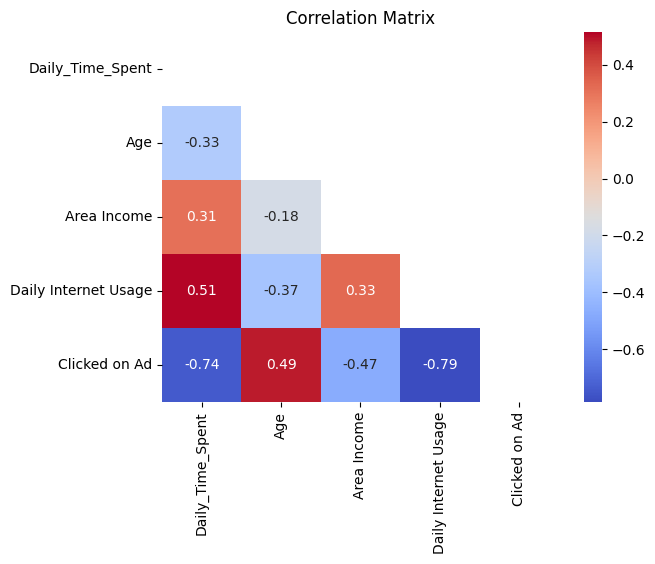

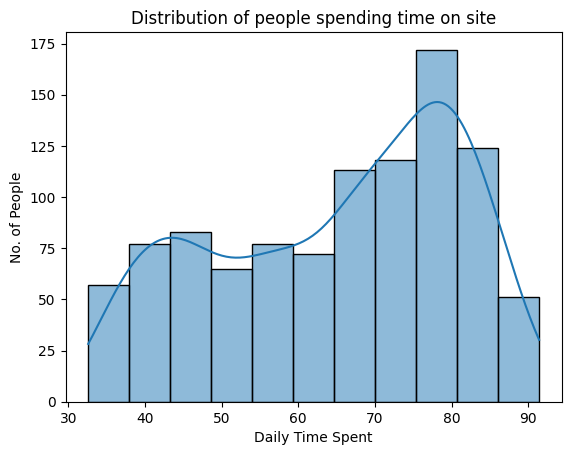

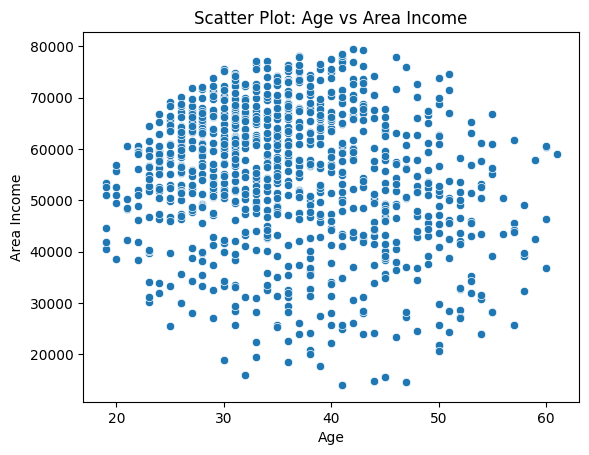

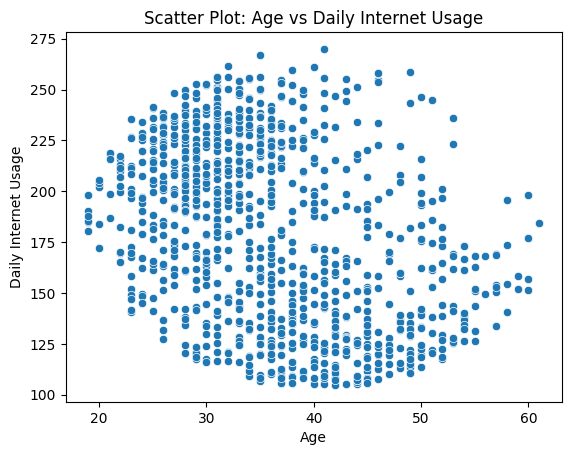

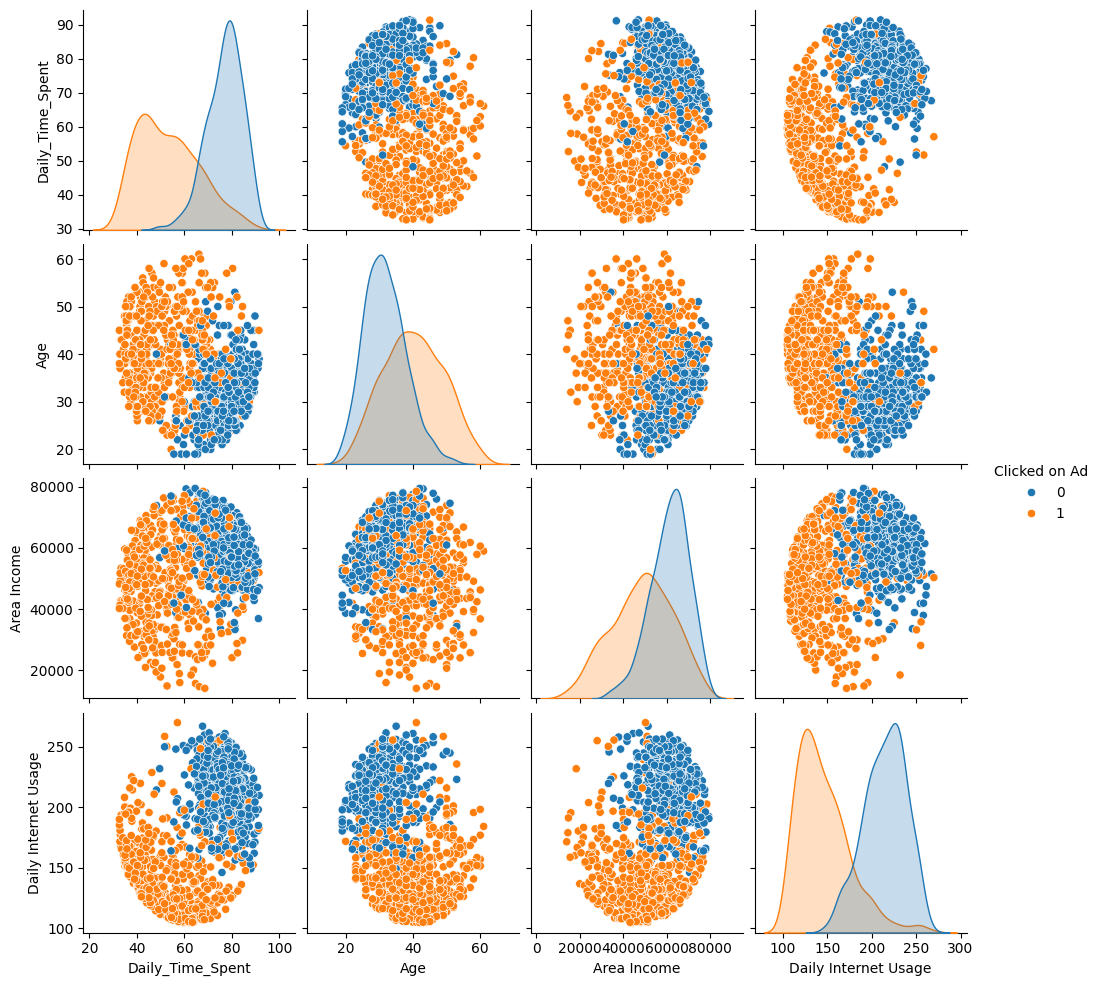

In [137]:
#Main Usage
url =('advertising_ef.csv')
df = pd.read_csv(url)

model_name = 'LR'
target_name1 = 'Gender'
target_name2 = 'Clicks on Ad'
#raw data
df.head()

# raw data info
df.info()

# Clean and preprocess the data
cleaned_df = clean_and_preprocess_data(df)

# Save the cleaned data to a new CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)

#cleaned data info
df.info()

#correlation matrix
visualize_correlation_matrix(df,'LR')

visualize_data(df,model_name)

# Target Variable - Gender

Value counts for Gender:
Gender
Female    525
Male      484
Name: count, dtype: int64



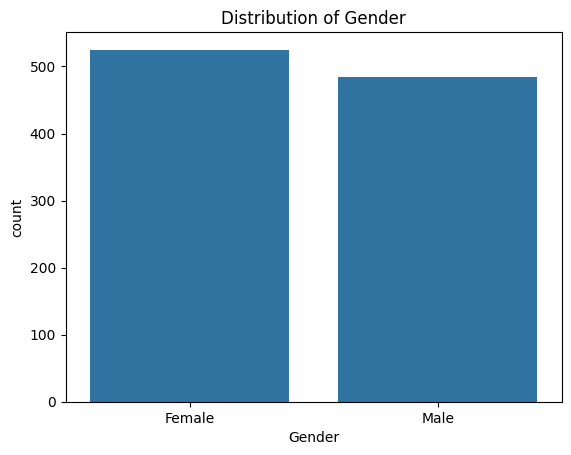

Target Variable: 0       0
1       1
2       0
3       1
4       0
       ..
1004    1
1005    1
1006    1
1007    0
1008    0
Name: Gender, Length: 1009, dtype: int64
Accuracy Score: 0.504950495049505
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.87      0.64       101
           1       0.52      0.14      0.22       101

    accuracy                           0.50       202
   macro avg       0.51      0.50      0.43       202
weighted avg       0.51      0.50      0.43       202

Confusion Matrix:
 [[88 13]
 [87 14]]
Mean Accuracy Score: 0.5061904761904762
Standard Deviation of Accuracy Score: 0.09353961654799306
F1 Score: 0.21875


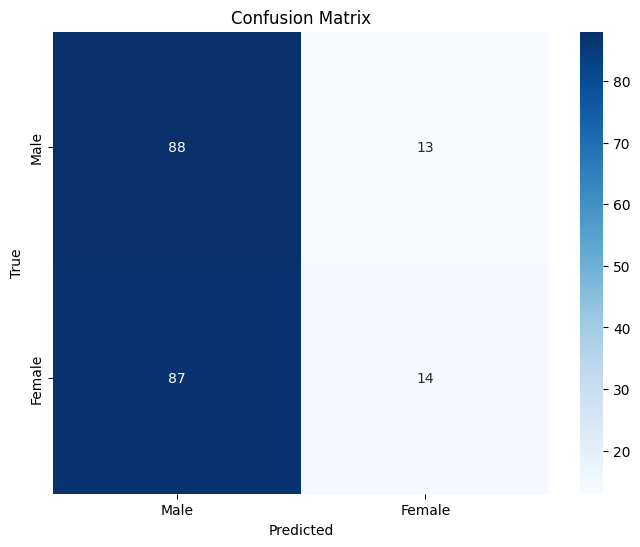

Metrics saved to LR_Gender_metrics.txt


In [138]:
# For Target Variable - Gender

categorical_features = ['Gender']
analyze_categorical_features(df, categorical_features,model_name, target_name1)
#Data Modeling
df = label_encode_categorical_column(df, 'Gender')

y = df['Gender']
X = df.iloc[:,[0,1,2,3,9]]
logistic_regression_model(df, y , X)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Calculate predicted probabilities
model = LogisticRegression(solver='lbfgs') # Define model here
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Plot and analyze the ROC curve
plot_roc_curve(y_test, y_pred_prob, model_name,target_name1)

#Confusion Matrix
y_pred = model.predict(X_test)
class_names = ['Male', 'Female']  # Replace with your actual class names
plot_confusion_matrix(y_test, y_pred, class_names,target_name1)

save_metrics_to_file(model_name, target_name1,y_test, y_pred_prob, model)

# Target Variable - Click on ads

Value counts for Clicked on Ad:
Clicked on Ad
1    506
0    503
Name: count, dtype: int64



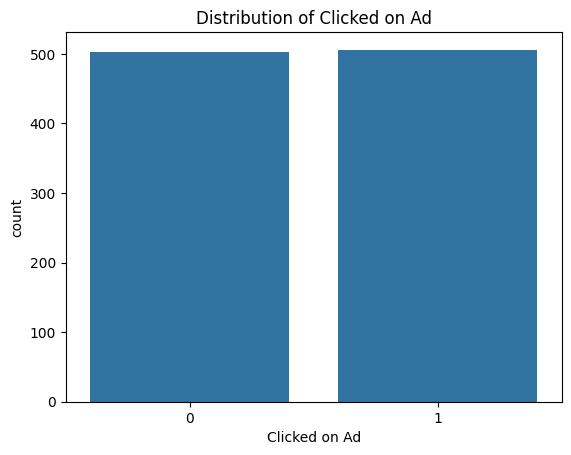

Target Variable: 0       0
1       0
2       0
3       0
4       0
       ..
1004    1
1005    1
1006    1
1007    0
1008    1
Name: Clicked on Ad, Length: 1009, dtype: int64
Accuracy Score: 0.9158415841584159
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91        88
           1       0.96      0.89      0.92       114

    accuracy                           0.92       202
   macro avg       0.91      0.92      0.92       202
weighted avg       0.92      0.92      0.92       202

Confusion Matrix:
 [[ 84   4]
 [ 13 101]]
Mean Accuracy Score: 0.9202380952380953
Standard Deviation of Accuracy Score: 0.06793228921777437
F1 Score: 0.9223744292237442


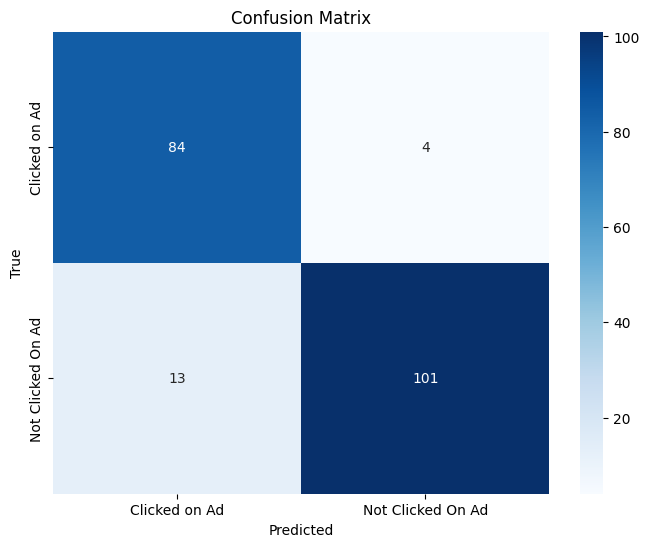

Metrics saved to LR_Clicks on Ad_metrics.txt


In [139]:
#For Target Variable - Clicked on Ads
categorical_features = ['Clicked on Ad']
analyze_categorical_features(df, categorical_features,model_name, target_name2)

Y = df['Clicked on Ad']
x= df.iloc[:,[0,1,2,3,6]]
logistic_regression_model(df,Y, x)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, shuffle=False)

# Calculate predicted probabilities
model = LogisticRegression(solver='lbfgs') # Define model here
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
# Plot and analyze the ROC curve
plot_roc_curve(y_test, y_pred_prob,model_name, target_name2)

y_pred = model.predict(X_test)
class_names = ['Clicked on Ad', 'Not Clicked On Ad']  # Replace with your actual class names
plot_confusion_matrix(y_test, y_pred, class_names,target_name2)

save_metrics_to_file(model_name, target_name2, y_test, y_pred_prob, model)

From the Logistic Regression Model we get -

**For Gender Prediction** :

Mean Accuracy Score: 0.5061904761904762    
Standard Deviation of Accuracy Score: 0.09353961654799306

From this, we can say that **Standard Deviation is high** and **Accuracy is not good enough.**

**For Ads**:

Mean Accuracy Score: 0.9202380952380953    
Standard Deviation of Accuracy Score: 0.06793228921777437

Therefore, We can say that **Standard Deviation is not very high** and **Accuracy is good enough.**


In [140]:
import pickle

In [141]:
with open('CP_LR_Complete_Model.pkl', 'wb') as file:
    pickle.dump(model, file)